In [352]:
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plttotal_num_pts
import pandas as pd
import math
import random

# Import Data from CSV

In [353]:
data = pd.read_csv('20210201_parsed_run3_data.csv',index_col=0)
# data['time'] -= 275.036 # let's start at 0 this shouldnt make a difference
# data['delta'] = (data['steer'].shift(-1) - data['steer']) / (data['time'].shift(-1) - data['time']) 

In [354]:
data.head()

,time,x,y,psi,vx,vy,r,steer,D,real_ax,real_ay
0,0.00,-0.000000,0.000000,-0.123003,13.915932,-0.126266,-0.19186,-0.036206,-0.149729,0.0504,-3.3986
1,0.04,-0.076279,0.551727,-0.130858,13.919109,-0.146419,-0.20621,-0.036868,-0.185031,0.1897,-2.9570
2,0.08,-0.156204,1.102882,-0.138590,13.919418,-0.127803,-0.19212,-0.037669,-0.180356,-0.2496,-1.5378
3,0.12,-0.240891,1.653343,-0.146515,13.918476,-0.123647,-0.20848,-0.038655,-0.150180,0.1214,-3.7601
4,0.16,-0.330551,2.202995,-0.154836,13.917126,-0.148707,-0.20355,-0.040018,-0.146335,-0.1553,-3.0901


# Bicycle Model

In [355]:
def tire_force(alpha, Fz, p):
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p
    return -alpha * cornering_stiff * (Fz / sample_fz)

def normal_force(vx, p):
    g = 9.8
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    # traction due to aero
    F_lift = 0.5*rho*cla*(vx**2)
    FzF = -(lr * (m * g + F_lift)) / l;
    FzR = -(lf * (m * g + F_lift)) / l;
    
    return FzF, FzR

def dynamic_model(t, x, p):
    x, y, psi, vx, vy, r, steer = x  # position
    D, delta = data['D'][int(t / 0.04)], data['delta'][int(t / 0.04)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    # estimate normal
    FzF, FzR = normal_force(vx, p)
    
    # compute slip angles
    alpha_f = math.atan((vy + r * lf) / vx) + steer
    alpha_r = math.atan((vy - r * lr) / vx)
    
    # compute tire forces
    F_yf = tire_force(alpha_f, FzF, p)
    F_yr = tire_force(alpha_r, FzR, p)
    
    # torque to force
    F_net = m * D
    
    # torque vectoring
    F_xf = lf / l * F_net
    F_xr = lr / l * F_net
    
    # accel
    ax = 1/m * (F_xr + F_xf * math.cos(steer) + F_yf * math.sin(steer)) + r * vy
    ay = 1/m * (F_yr - F_xf * math.sin(steer) + F_yf * math.cos(steer)) - r * vx
    a_yaw = 1/Iz * (-lf * F_xf * math.sin(steer) + lf * F_yf * math.cos(steer) - lr * F_yr)
    
    # bicycle model
    new_vx = vx * math.cos(psi) - vy * math.sin(psi)  # sin/cos(x), x should be radians.. not sure if our data is in deg/rad
    new_vy = vx * math.sin(psi) + vy * math.cos(psi)
    
    return [new_vx, new_vy, r, ax, ay, a_yaw, delta]
    
    
def kinematic_model(t, x, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = data['D'][math.floor(t / 0.04)], data['steer'][math.floor(t / 0.04)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    beta = math.atan((math.tan(-steer) * lr)/l)
    ax = D * math.cos(beta)
    ay = D * math.sin(beta)
    
    dx = vx * math.cos(psi + beta)
    dy = vx * math.sin(psi + beta)
    dpsi = math.tan(-steer) * (vx * math.cos(beta)) / l # Note: R.Rajamani uses opposite steering coordinates
    
    dvx = ax
    dvy = ay
    dr = vx / lr * math.sin(beta)
    
    return np.array([dx, dy, dpsi, ax, ay, dr])


In [381]:
# # defining our variables for our simulated data
# y0 = [data[c][0] for c in data.columns[1:7]]
# timespan = 10
# num_pts = 25*timespan + 1
# tspan = np.linspace(0, timespan, num_pts)
# p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (357, 2.971, 2.01, 0.960, 550.0, 125116, 4000, 1.225, -1.034)
# # p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (350.0, 2.6, 1.2, 1.4, 550.0, 1000.0, 3430.0, 1.2, -0.5)

# defining our variables for our simulated data
y0 = [data[c][0] for c in data.columns[1:7]]
timespan = 30
num_pts = 25*timespan + 1
tspan = np.linspace(0, timespan, num_pts)
p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (357, 2.971, 2.01, 0.960, 550.0, 125116, 4000, 1.225, -1.034)
# p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (350.0, 2.6, 1.2, 1.4, 550.0, 1000.0, 3430.0, 1.2, -0.5)

In [390]:
total_timespan = 10
total_num_pts = 25*total_timespan + 1
total_tspan = np.linspace(0, total_timespan, total_num_pts)
integration_timespan = 0.04
integration_num_pts = 25 * integration_timespan + 1
integration_tspan = np.linspace(0, integration_timespan, integration_num_pts)

In [391]:
def integrate(total_timespan, integration_timspan, data, p0):
#     sol = np.empty((1, 6))
#     sol[0] = data[data.columns[1:7]].iloc[0]
    sol = np.empty((0,6))
    for i in range(int(total_timespan*25)+1):
#         y0 = [data[c][i] for c in data.columns[1:7]]
        y0 = data[data.columns[1:7]].iloc[i]
        int_sol = solve_ivp(kinematic_model, (0, integration_timespan), y0, t_eval=integration_tspan, args=(p0,), rtol=1e-5, atol=1e-5)
        int_sol = np.swapaxes(int_sol.y, 0, 1)
        sol = np.append(sol, int_sol[1:,:], axis=0)
        
    return sol

In [392]:
sol = integrate(total_timespan, integration_timespan, data, p0)

In [393]:
sol.shape

(251, 6)

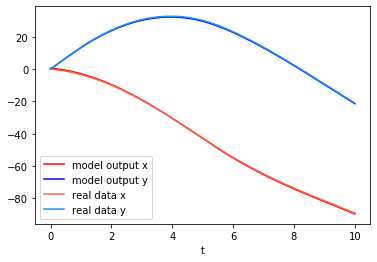

In [394]:
# let's plot this solution to see what it looks like against the real
plt.plot(total_tspan, sol[:,0], 'r', label='model output x')
plt.plot(total_tspan, sol[:,1], 'b', label='model output y')
plt.plot(total_tspan, data['x'][:total_num_pts], 'tomato', label='real data x')
plt.plot(total_tspan, data['y'][:total_num_pts], 'dodgerblue', label='real data y')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

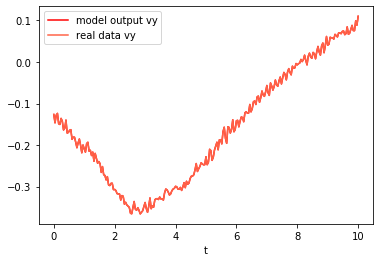

In [395]:
# let's plot this solution to see what it looks like against the real
plt.plot(total_tspan, sol[:,4], 'r', label='model output vy')
plt.plot(total_tspan, data['vy'][:total_num_pts], 'tomato', label='real data vy')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

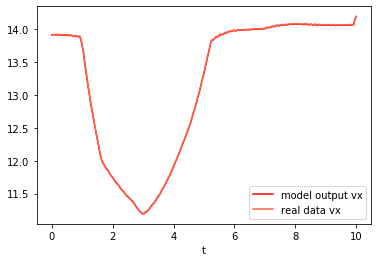

In [396]:
# let's plot this solution to see what it looks like against the real
plt.plot(total_tspan, sol[:,3], 'r', label='model output vx')
plt.plot(total_tspan, data['vx'][:total_num_pts], 'tomato', label='real data vx')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

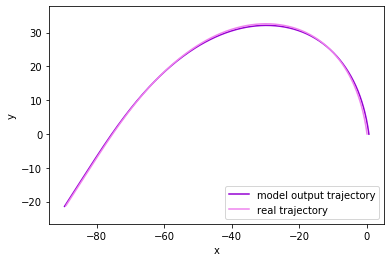

In [397]:
# let's plot just the xy trajectory
plt.plot(sol[:,0], sol[:,1], 'darkviolet', label='model output trajectory')
plt.plot(data['x'][:total_num_pts], data['y'][:total_num_pts], 'violet', label='real trajectory')
# plt.plot(data['x'], data['y'], 'violet', label='real trajectory')
plt.axis('equal')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Parameter Estimation

In [398]:
def plot_params(p, t, num_pts, data):
    new_sol = integrate(total_timespan, integration_timespan, data, p)
    
    # let's plot this solution to see what it looks like against the real
    plt.plot(t, new_sol[:, 0], 'r', label='model output x')
    plt.plot(t, data['x'][:num_pts], 'tomato', label='real x')
    plt.plot(t, new_sol[:, 1], 'b', label='model output y')
    plt.plot(t, data['y'][:num_pts], 'dodgerblue', label='real y')
#     plt.plot(t, new_sol[:, 2], 'g', label='model output psi')
#     plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    # let's plot the velocity too
    plt.plot(t, new_sol[:, 3], 'r', label='model output vx')
    plt.plot(t, data['vx'][:num_pts], 'tomato', label='real vx')
    plt.plot(t, new_sol[:, 4], 'b', label='model output vy')
    plt.plot(t, data['vy'][:num_pts], 'dodgerblue', label='real vy')
#     plt.plot(t, new_sol[:, 5], 'g', label='model output r')
#     plt.plot(t, data['r'][:num_pts], 'springgreen', label='real r')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    
    # let's plot just the xy trajectory
    plt.plot(new_sol[:, 0], new_sol[:, 1], 'darkviolet', label='model output trajectory')
    plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [399]:
sol = data[data.time.between(0, total_timespan)][data.columns[1:7]].to_numpy()

In [400]:
# TODO: probably want to normalize this error
# l2 = np.square(sol - pred).sum()

def cost(p):
    pred = integrate(total_timespan, integration_timespan, data, p)
    return np.square(sol[:,[0, 1, 3, 4]] - pred[:,[0, 1, 3, 4]]).sum()

In [401]:
pred = integrate(total_timespan, integration_timespan, data, p0)
print(pred[:,[0, 1, 3, 4]])

[[ 5.53280020e-01 -5.99310778e-02  1.39098881e+01 -1.26336457e-01]
 [ 4.76639795e-01  4.87437672e-01  1.39130677e+01 -1.46489610e-01]
 [ 3.96212900e-01  1.03431792e+00  1.39133787e+01 -1.27873460e-01]
 ...
 [-8.89295863e+01 -2.04811258e+01  1.40669875e+01  9.92617981e-02]
 [-8.92394277e+01 -2.09586257e+01  1.41446395e+01  8.86545704e-02]
 [-8.95498590e+01 -2.14344620e+01  1.41888404e+01  1.10166311e-01]]


In [402]:
print(sol[:,[0, 1, 3, 4]])

[[-0.00000000e+00  0.00000000e+00  1.39159317e+01 -1.26265660e-01]
 [-7.62786865e-02  5.51727295e-01  1.39191093e+01 -1.46418840e-01]
 [-1.56204224e-01  1.10288239e+00  1.39194183e+01 -1.27802715e-01]
 ...
 [-8.84600830e+01 -2.01707764e+01  1.40731611e+01  9.93342623e-02]
 [-8.87674866e+01 -2.06463318e+01  1.41508131e+01  8.87270346e-02]
 [-8.90766907e+01 -2.11208191e+01  1.41950140e+01  1.10238776e-01]]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


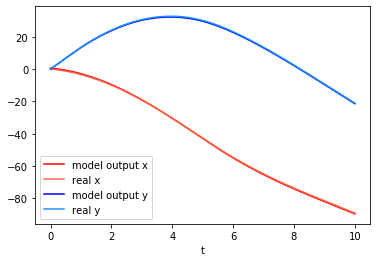

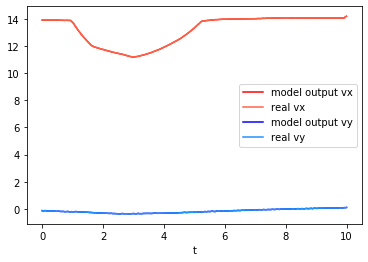

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


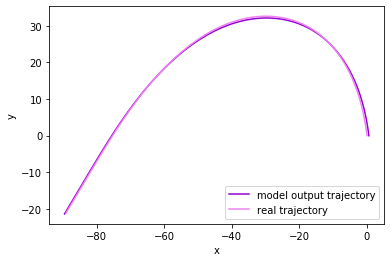

In [403]:
plot_params(p0, total_tspan, total_num_pts, data)

In [405]:
minimization = minimize(cost, p0, method='Nelder-Mead', tol=1e-3, options={'maxiter':1e3})

In [406]:
# m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla
minimization.x

array([ 6.35917979e+02,  3.68344852e-05,  3.70360102e+00, -1.76164147e-03,
        1.13553446e+03,  1.79112584e+05,  5.98921708e+01,  8.58380033e-01,
       -1.10000366e+00])